In [20]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [21]:
employee = pd.read_csv("../data/employee_cleaned.csv")
employee.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,Duration
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0,3
1,Bachelors,2013,Pune,1,28,Female,No,3,1,7
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0,6
3,Masters,2016,Bangalore,3,27,Male,No,5,1,4
4,Masters,2017,Pune,3,24,Male,Yes,2,1,3


In [22]:
#employee['Education'].replace({'PHD': 'a', 'Masters': 'b', 'Bachelors': 'c'}, inplace=True)
employee['Education'].replace(to_replace = ['PHD', 'Masters', 'Bachelors'], value = ['3', '2', '1'], inplace = True)
employee['Education'] = employee['Education'].astype('int64')
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  2764 non-null   int64 
 1   JoiningYear                2764 non-null   int64 
 2   City                       2764 non-null   object
 3   PaymentTier                2764 non-null   int64 
 4   Age                        2764 non-null   int64 
 5   Gender                     2764 non-null   object
 6   EverBenched                2764 non-null   object
 7   ExperienceInCurrentDomain  2764 non-null   int64 
 8   LeaveOrNot                 2764 non-null   int64 
 9   Duration                   2764 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 216.1+ KB


## Split the data into training and test sets

In [23]:
employee_train, employee_test = train_test_split(employee, test_size = 0.40, random_state = 7)
print(employee.shape)
print(employee_train.shape)
print(employee_test.shape)

(2764, 10)
(1658, 10)
(1106, 10)


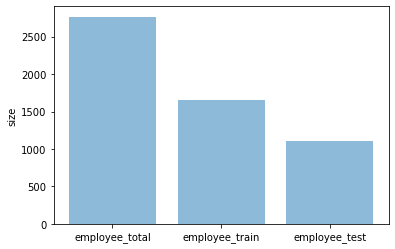

In [24]:
portion = ('employee_total', 'employee_train', 'employee_test')
y_pos = np.arange(len(portion))
size = [2764,1658,1106]

plt.bar(y_pos, size, align='center', alpha=0.5)
plt.xticks(y_pos, portion)
plt.ylabel('size')

plt.show()

### Separate data frames for interested predictor variables and response variable

### *Data with all predictor variables

In [25]:
#---Training set---

x_all = employee_train.drop(['LeaveOrNot'], axis= 1)
x_all = pd.get_dummies(x_all)
y_all = employee_train[['LeaveOrNot']]
y_names_all = ["No", "Yes"]

#---Test set---

x_test_all = employee_test.drop(['LeaveOrNot'], axis= 1)
x_test_all = pd.get_dummies(x_test_all)
y_test_all = employee_test[['LeaveOrNot']]

x_all.head(2)


,Education,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,Duration,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes
2040,1,2017,3,33,5,3,0,0,1,0,1,0,1
1872,1,2016,3,40,0,4,1,0,0,0,1,1,0


In [26]:
#Change response variable to one-dimension array 
rfy_all = np.ravel(y_all)

In [27]:
#The n_estimators= 100, criterion  = "gini" id default (don't have to specufy)--
#--set max_depth to limit the depth of the tree, or limit branches
#--Set random_state for reproducible results
rf_all = RandomForestClassifier(n_estimators = 100, \
                              criterion = "gini", max_depth=5, random_state = 42).fit(x_all,rfy_all)

y_train_pred_all = rf_all.predict(x_all)
y_train_pred_all 

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

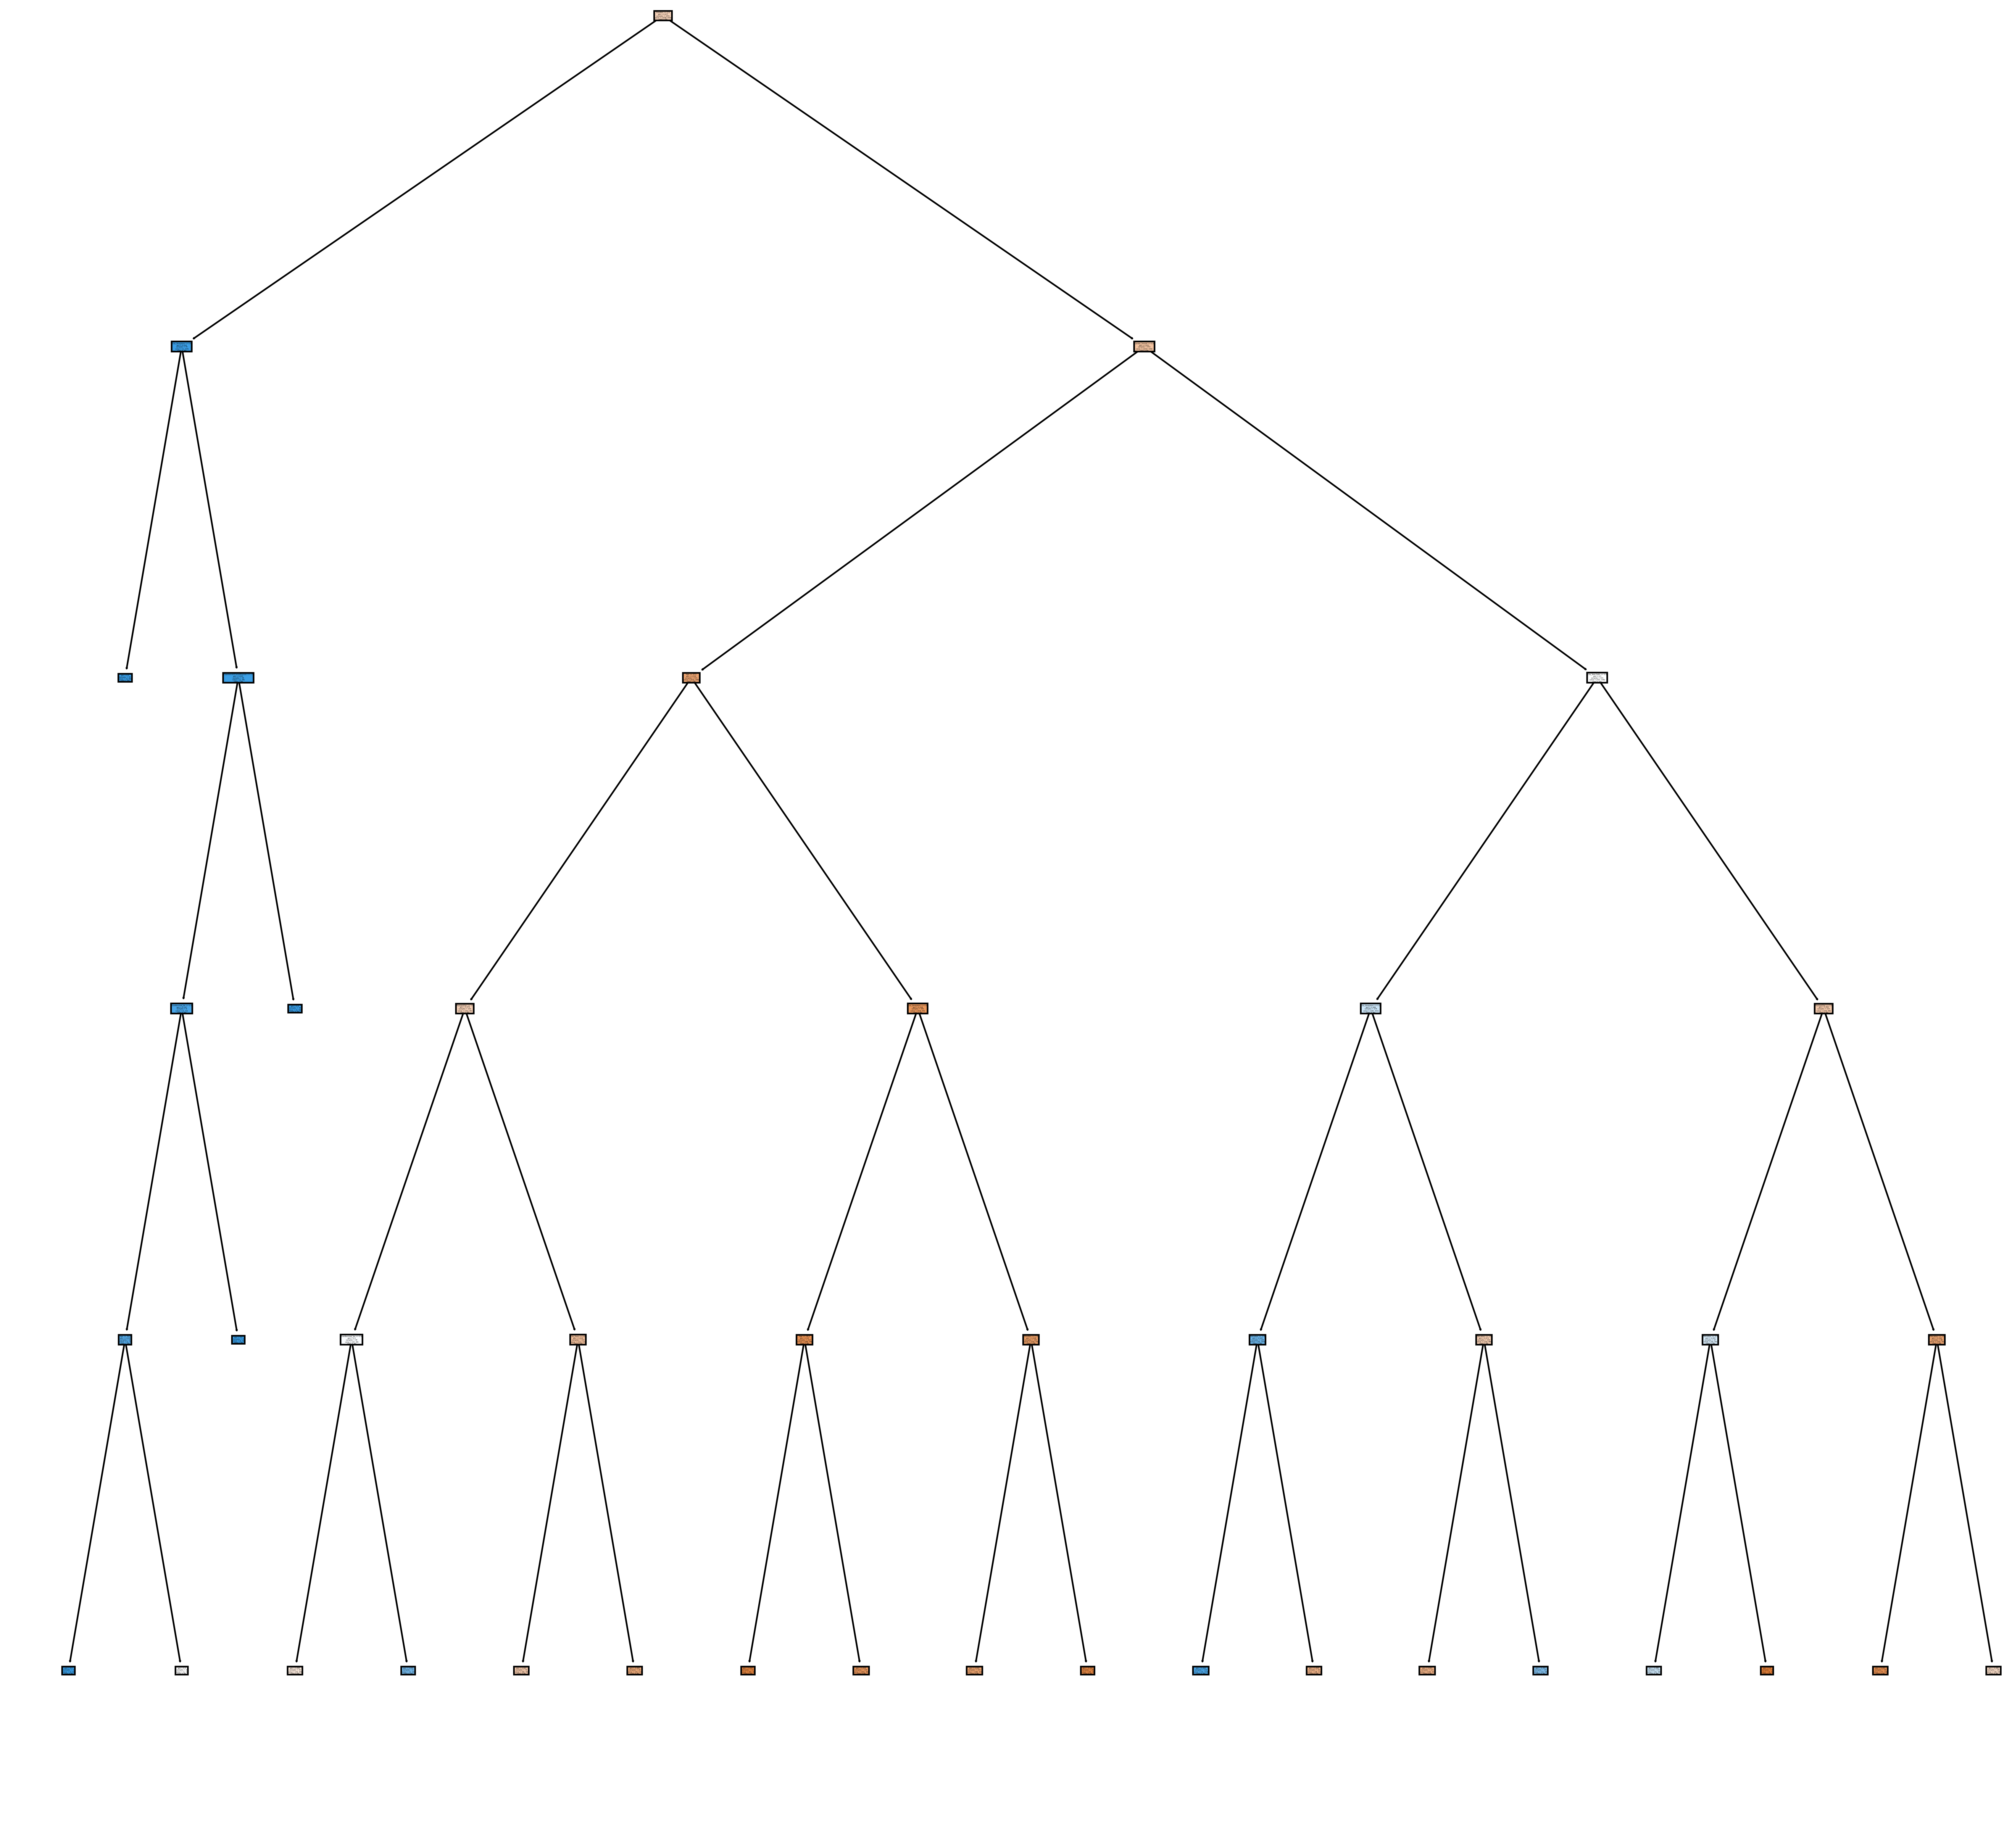

In [28]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=400)
#use .estimator[] to specify individual tree 
tree.plot_tree(rf_all.estimators_[0],
               feature_names = x_all.columns.values, 
               class_names=y_names_all,
               filled = True);
fig.savefig('rf_all_individualtree.png')

In [29]:
#Make prediction
y_pred_all = rf_all.predict(x_test_all)

#count number of predict for each class
unique, counts = np.unique(y_pred_all, return_counts=True)
dict(zip(unique, counts))

{0: 818, 1: 288}

In [30]:
print("Accuracy:",metrics.accuracy_score(y_test_all, y_pred_all))
print("Precision:",metrics.precision_score(y_test_all, y_pred_all))
print("Recall:",metrics.recall_score(y_test_all, y_pred_all))

Accuracy: 0.7631103074141049
Precision: 0.8368055555555556
Recall: 0.5285087719298246


In [31]:
#Feature importance
feature_scores_all = pd.Series(rf_all.feature_importances_, index= x_all.columns).sort_values(ascending=False)

feature_scores_all

Duration                     0.227348
JoiningYear                  0.223179
PaymentTier                  0.134139
City_Pune                    0.083759
Education                    0.076733
Gender_Male                  0.067233
Gender_Female                0.066949
Age                          0.045255
City_Bangalore               0.026260
ExperienceInCurrentDomain    0.016981
City_New Delhi               0.015509
EverBenched_Yes              0.008379
EverBenched_No               0.008276
dtype: float64

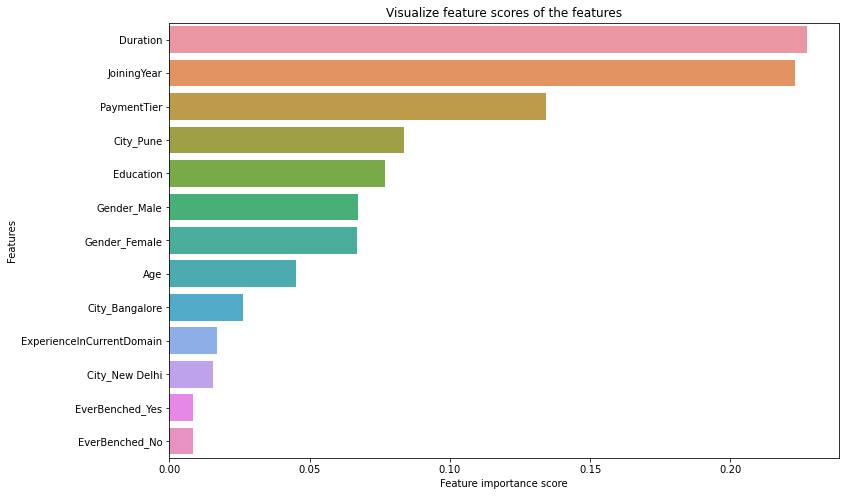

In [32]:
# Creating a seaborn bar plot
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x=feature_scores_all, y=feature_scores_all.index, data = x_all[[]])
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores_all.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

### --> It seems Duration, PaymentTier,  Education  and City are a good candidate for a simplified model

### *Data with Duration, PaymentTier, Education and City as predictor variables

In [33]:
#---Training set---

x = employee_train[['Duration', 'PaymentTier', 'Gender', 'City']]
x = pd.get_dummies(x)
y = employee_train[['LeaveOrNot']]
x_names = ['Duration', 'PaymentTier', 'Gender']
x_names = x.columns.values
y_names = ["No", "Yes"]

#---Test set---

x_test = employee_test[['Duration', 'PaymentTier', 'Gender', 'City']]
x_test = pd.get_dummies(x_test)
y_test = employee_test[['LeaveOrNot']]
x_test_names = x_test.columns
y_test_names = ["No", "Yes"]

x.head(2)

,Duration,PaymentTier,Gender_Female,Gender_Male,City_Bangalore,City_New Delhi,City_Pune
2040,3,3,0,1,0,0,1
1872,4,3,0,1,1,0,0


In [34]:
#Change response variable to one-dimension array 
rfy = np.ravel(y)

In [35]:
#The n_estimators= 100, criterion  = "gini" id default (don't have to specufy)--
#--set max_depth to limit the depth of the tree, or limit branches
#--Set random_state for reproducible results
rf = RandomForestClassifier(n_estimators = 100, \
                              criterion = "gini", max_depth=5, random_state = 42).fit(x,rfy)

y_train_pred = rf.predict(x)
y_train_pred 

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

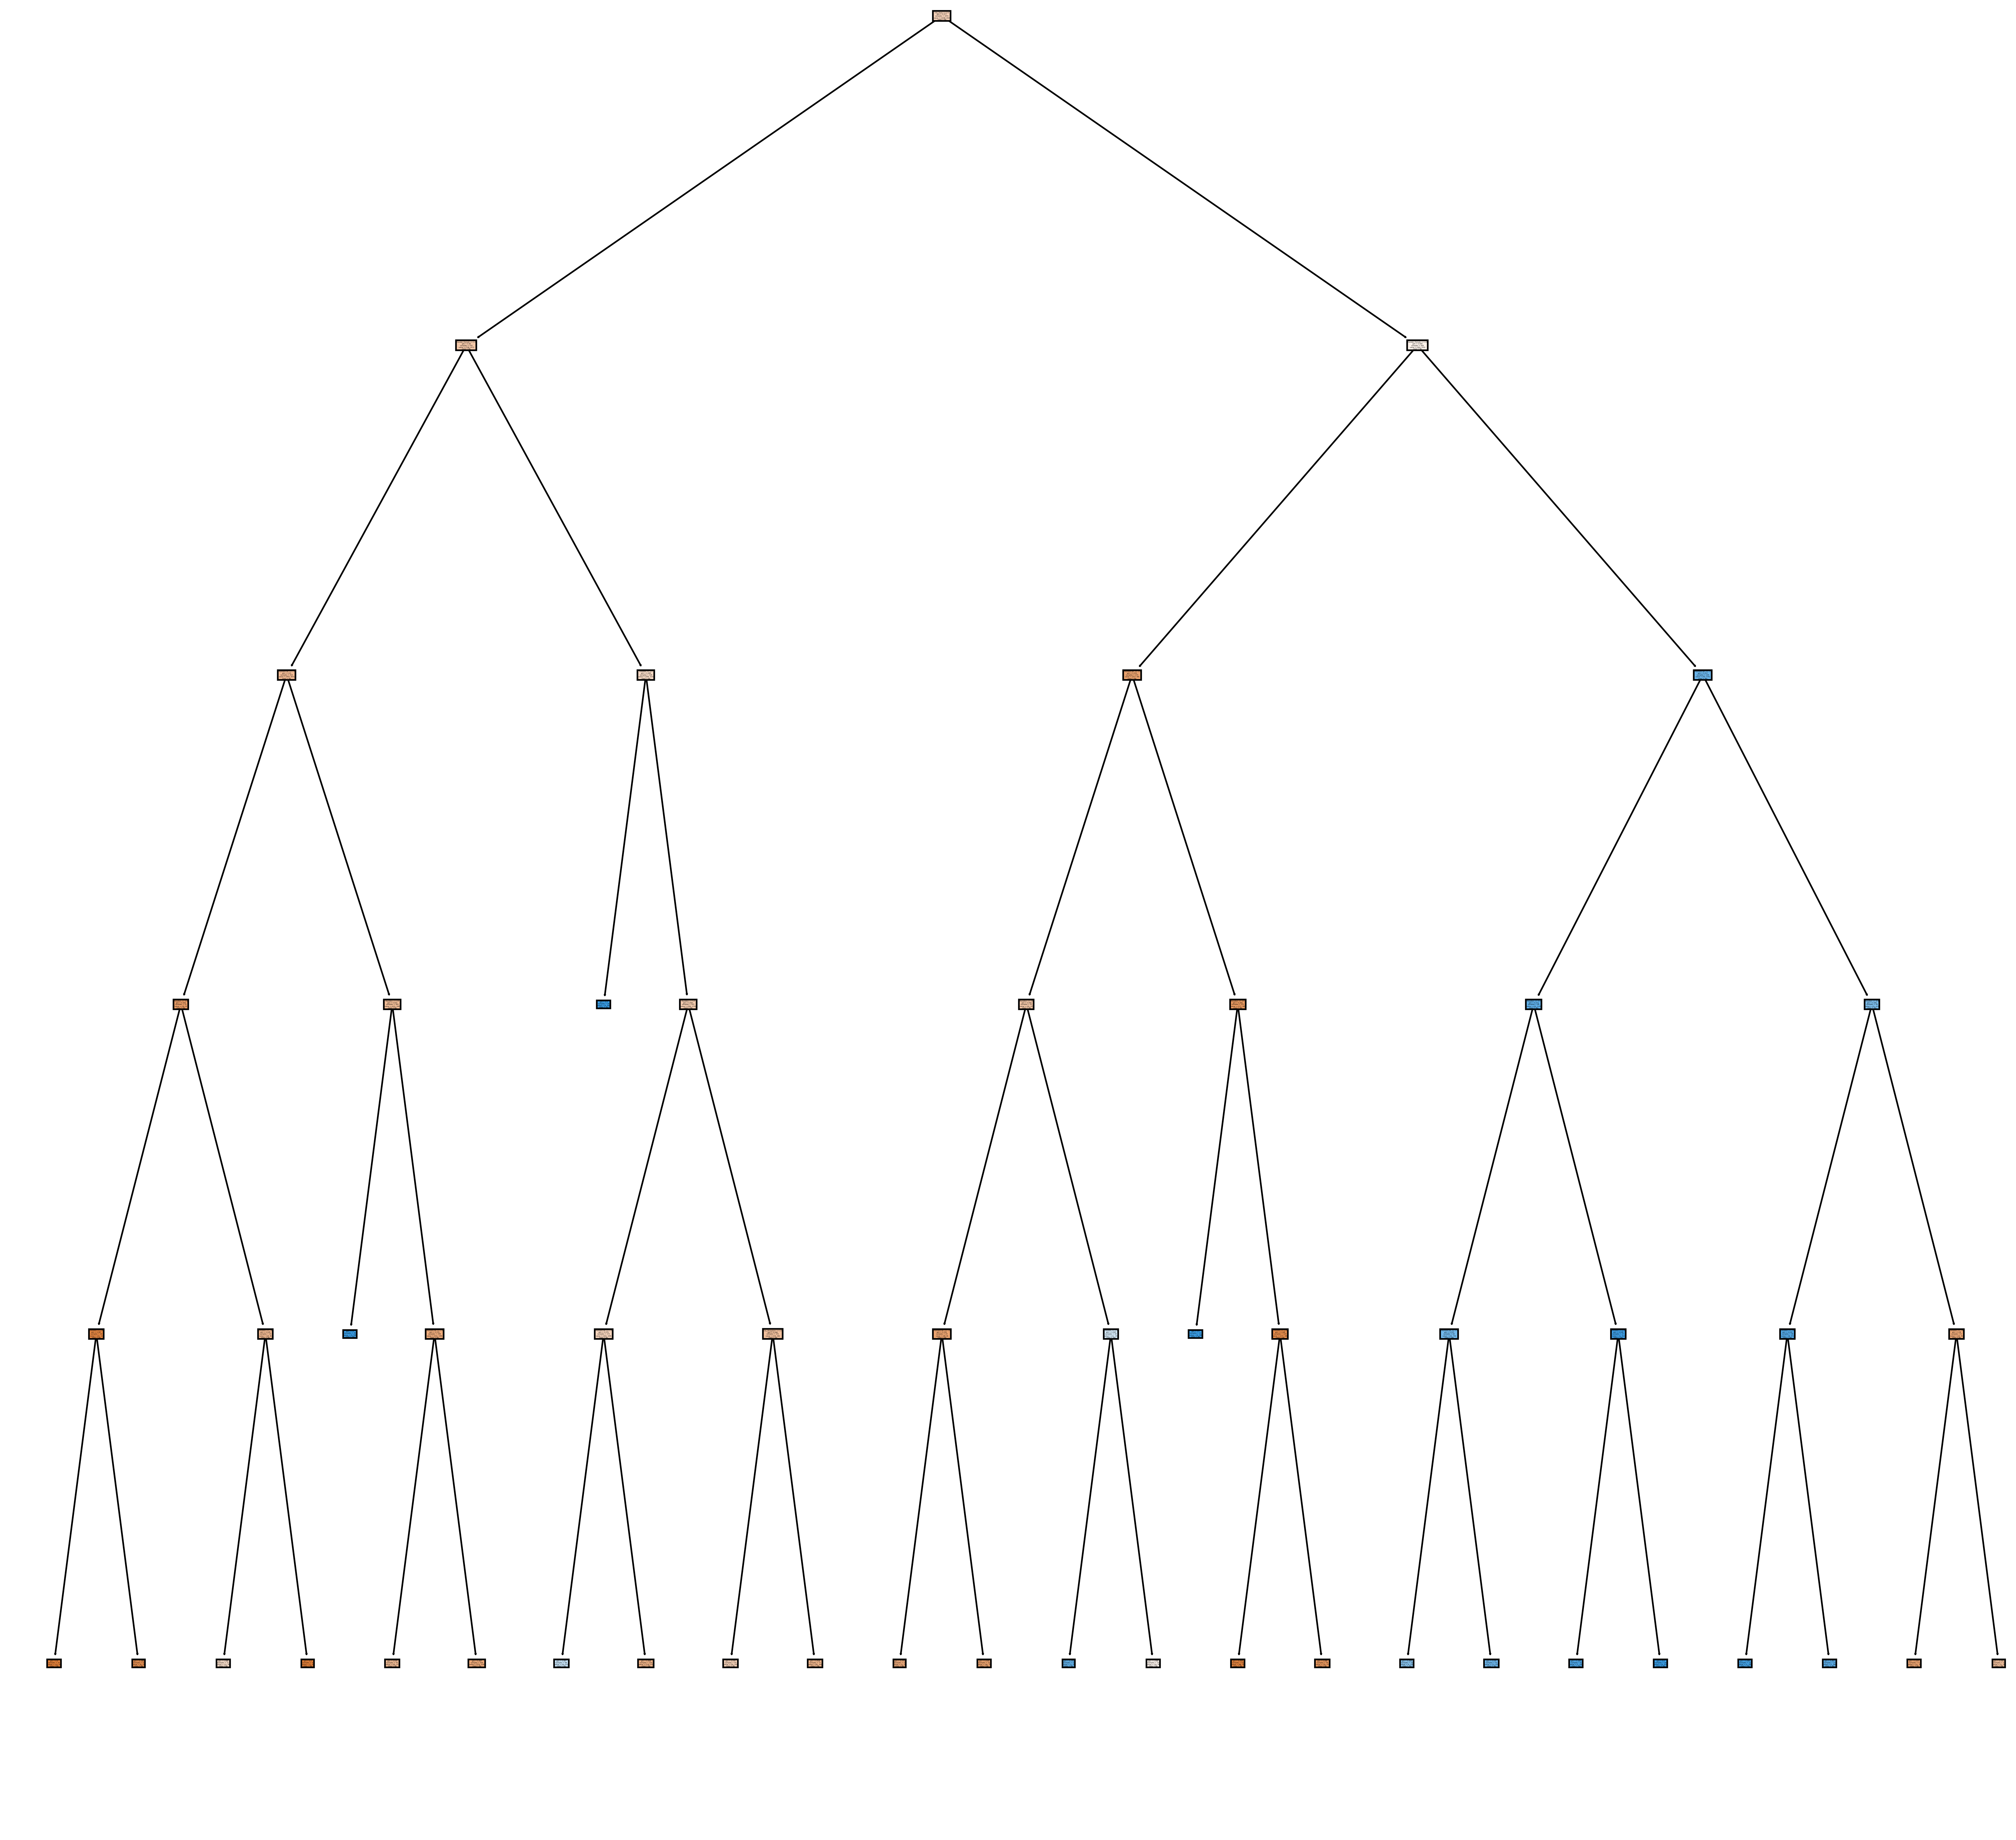

In [36]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=400)
#use .estimator[] to specify individual tree 
tree.plot_tree(rf.estimators_[0],
               feature_names = x.columns.values, 
               class_names=y_names,
               filled = True);
fig.savefig('rf_individualtree.png')

In [37]:
#Make prediction
y_pred2 = rf.predict(x_test)

#count number of predict for each class
unique, counts = np.unique(y_pred2, return_counts=True)
dict(zip(unique, counts))

{0: 808, 1: 298}

In [38]:
#calculate the Evaluation measure based on the contingency above
TN, FP, FN, TP = confusion_matrix(y_test, y_pred2).ravel()
Specificity2 = TN / (TN+FP)
Accuracy2 = metrics.accuracy_score(y_test, y_pred2)
Precision2 = metrics.precision_score(y_test, y_pred2)
Recall2 = metrics.recall_score(y_test, y_pred2)
F1_Score2 = metrics.f1_score(y_test, y_pred2)
ErrorRate2 = 1-Accuracy2
F2_Score2 = (5*Precision2*Recall2)/((4*Precision2)+Recall2)
F0point5_Score2 = (1.25*Precision2*Recall2)/((0.25*Precision2)+Recall2)

print("Accuracy:", Accuracy2)
print("Precision:", Precision2)
print("Recall:", Recall2 )


Accuracy: 0.7703435804701627
Precision: 0.8389261744966443
Recall: 0.5482456140350878
